In [109]:
import sys
import os
import numpy as np
import pandas as pd
import random
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import shapefile as sh
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import shape, box, LineString, MultiPolygon, Polygon, MultiPoint, Point, LinearRing
from shapely import wkt
from shapely.wkt import loads
from shapely.ops import unary_union
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.__version__}")
print(f"Shapely GEOS version {shapely.geos_version_string}")
print(f"Shapely GEOS C API version {shapely.geos_capi_version_string}")

# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

Py version 3.8.10
Shapely version 2.0.1
Shapely GEOS version 3.11.1
Shapely GEOS C API version 3.11.1-CAPI-1.17.1
RasDaMan is running


In [12]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_ring(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    ring = LinearRing(zip(long_array, lat_array))
    return ring
  
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)

    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

def processRING(ring):
    lat_arr = []
    long_arr = []
    if ring.is_closed == True:
        # Extract longitudes and latitudes
        longitudes, latitudes = zip(ring.xy)
        
        for i in range(len(latitudes[0])):
            long_arr = np.append(long_arr, longitudes[0][i])
            lat_arr = np.append(lat_arr, latitudes[0][i])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridRING_yx = grid2WKT_ring(y_grid, x_grid)

        return gridRING_yx
    else:
        print("Incomplete ring")

        
def processPOLYGON(inputPOLYGON, regionID = None):
    if len(inputPOLYGON.interiors) == 0:
        polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        lat_arr = []
        long_arr = []
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

        return gridPOLYGON_yx
    else:
        print(f"{regionID}: Polygon Ring Detected")
        mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
        gridPOLYGON_yx = processPOLYGON(mainPOLYGON)
#         for i in range(0, len(inputPOLYGON.interiors)):
#             gridRING_yx = processRING(inputPOLYGON.interiors[i])
        
#         gridPOLYGON_yx_assembled = gridPOLYGON_yx.symmetric_difference(Polygon(gridRING_yx))
        
        return gridPOLYGON_yx #return gridPOLYGON_yx_assembled
           

######## Mother Function ##############################################################################################
########################################################################################

def geoPOLYGON_to_gridPOLYGON_03(inputREGION, regionID = None):
    polygons_array1 = []
    polygons_array2 = []
    i = 0
    r = 0
    if inputREGION.geom_type == 'Polygon':
        print(f"{regionID}: Polygon is processing")
        return processPOLYGON(inputREGION, regionID)
    
    elif len(list(inputREGION.geoms[0].interiors)) > 0:    # MultiPolygon with atleast 1 inner rings
        print(f"{regionID}: MultiPolygon has Inner Rings")        
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array1.append(gridPOLYGON)
            r = r +1
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array1]
        return shapely.geometry.MultiPolygon(gridMULTI)

    else:                                                  # MultiPolygon with 0 rings
        print(f"{regionID}: MultiPolygon is processing")
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array2.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array2]
        return shapely.geometry.MultiPolygon(unary_union(gridMULTI))
#         return shapely.geometry.MultiPolygon(gridMULTI)

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
######## GIS F(X) ##############################################################################################
################################################################################################################


def query2numeric(query):
    result = query_executor.execute_read(query) 
    return float("{}".format(result))

def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    print(type(result))
    return result

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap( data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return True #return numpy_array  


def vizVectorGeom(input_geom):
#     geojson = {'type': 'Polygon', 'coordinates': [[[34, 31], [32, 31], [34, 33]]]}
    gdf = gpd.GeoDataFrame({'geometry':[shape(input_geom)]}, crs='EPSG:4326')
    ax = gdf.plot(facecolor='#80a4ff33', edgecolor='red', linewidth=1)
    cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=10)
    plt.show()
    print(input_geom.geom_type)

In [3]:
gdfBAV = gpd.read_file('/home/arkaghosh/Downloads/Baveria/Vector/Baveria_1.shp')
gdfSWE = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/SWE_adm/SWE_adm2.shp')
raster01_path = '/home/arkaghosh/Downloads/Baveria/Raster/Baveria_Temp_MOD11A1.061_1km_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc'

In [4]:
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
lst_var = f['LST_Night_1km'].values

In [5]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())

ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [6]:
pixel_size = 0.00833333333258679

### München (I)

München


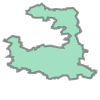

In [201]:
gid = 58 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

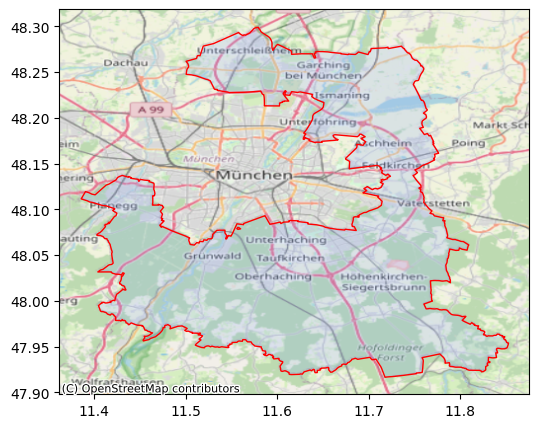

Polygon


In [202]:
vizVectorGeom(INPUT)

In [203]:
qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

58: Polygon is processing
58: Polygon Ring Detected


11.003744360902287

58: Polygon is processing
58: Polygon Ring Detected


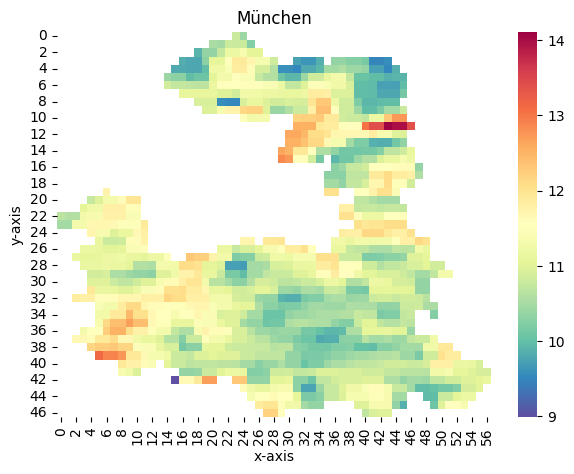

True

In [204]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gdfBAV.NAME_2[gid]), 0)

### Würzburg (II)

Würzburg


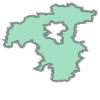

In [288]:
gid = 94 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

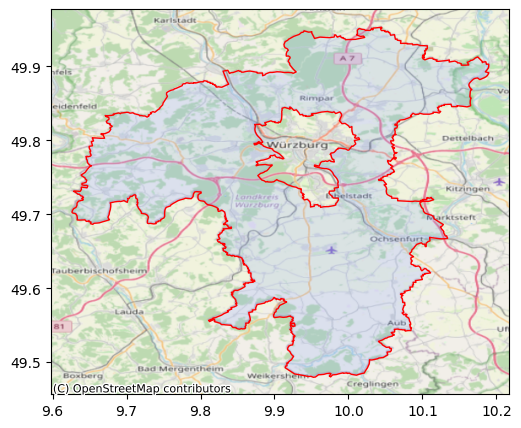

Polygon


In [206]:
vizVectorGeom(INPUT)

In [207]:
len(INPUT.interiors)

1

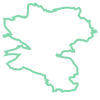

In [208]:
INPUT.interiors[0] # 1

In [232]:
ring_x, ring_y = INPUT.interiors[0].coords.xy

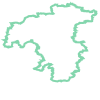

In [209]:
INPUT.exterior

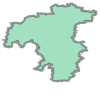

In [210]:
Polygon(INPUT.exterior)

In [233]:
poly_x, poly_y = INPUT.exterior.coords.xy

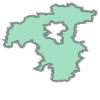

In [211]:
Polygon(INPUT.exterior) - Polygon(INPUT.interiors[0])

In [213]:
gridPOLYGON = processPOLYGON((Polygon(INPUT.exterior)))

In [214]:
print(type(gridPOLYGON))

<class 'str'>


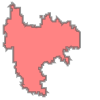

In [215]:
shapely.wkt.loads(gridPOLYGON)

In [216]:
gridPOLYGON_X = shapely.wkt.loads(gridPOLYGON)

In [217]:
print(type(gridPOLYGON_X))

<class 'shapely.geometry.polygon.Polygon'>


In [267]:
gridRING = processRING(INPUT.interiors[0])

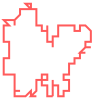

In [268]:
gridRING

In [269]:
print(type(gridRING))

<class 'shapely.geometry.polygon.LinearRing'>


In [273]:
new_polygon_with_hole = Polygon(gridPOLYGON_X.exterior, [gridRING])

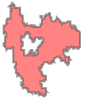

In [276]:
new_polygon_with_hole

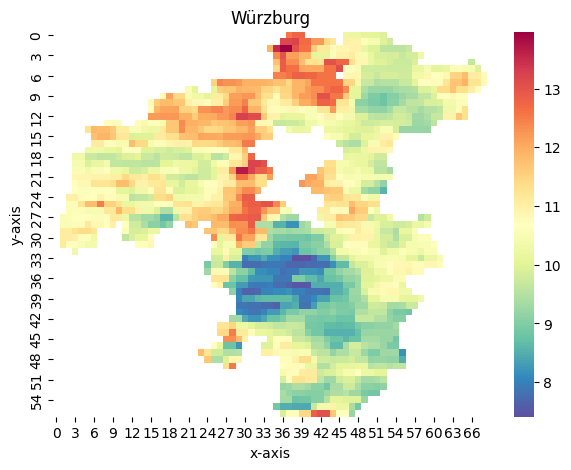

True

In [280]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(new_polygon_with_hole) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gdfBAV.NAME_2[gid]), 0)

In [281]:
qAGGREGATE= 'select avg_cells(clip(m[273, 0:* , 0:*],'+ str(new_polygon_with_hole) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

14174.98246518824

### BEFORE Update

In [47]:
qAGGREGATE= 'select avg_cells(clip(m[273, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

94: Polygon is processing
94: Polygon Ring Detected


14178.514383227694

94: Polygon is processing
94: Polygon Ring Detected


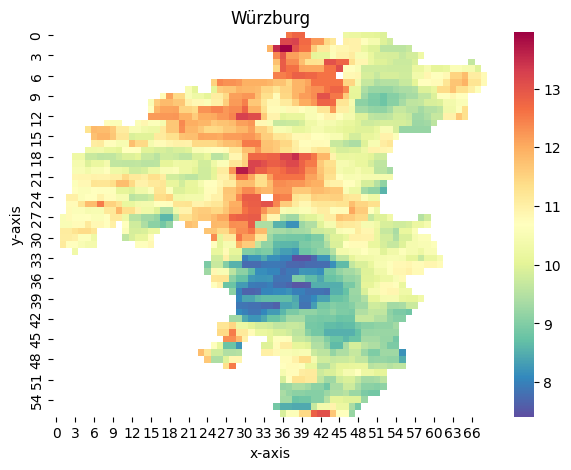

True

In [48]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gdfBAV.NAME_2[gid]), 0)

In [ ]:
# from shapely.geometry import Polygon, LinearRing

# # Input polygon coordinates
# input_polygon_coords = [(14.920806884765627, 49.48953847306649),
#                         (14.706573486328127, 48.685520874402016),
#                         (16.51931762695313, 48.99463598353407),
#                         (14.920806884765627, 49.48953847306649)]

# # Input linear ring coordinates
# input_linear_ring_coords = [(15.019683837890627, 49.18170338770662),
#                             (15.802459716796875, 49.152969656170455),
#                             (14.959259033203127, 48.833989576686065),
#                             (15.019683837890627, 49.18170338770662)]

# # Create Shapely geometries
# polygon = Polygon(input_polygon_coords)
# linear_ring = LinearRing(input_linear_ring_coords)

# # Create the new polygon with a hole
# new_polygon_with_hole = Polygon(polygon.exterior, [linear_ring])

# print(new_polygon_with_hole)

### Bayreuth (III)

Bayreuth


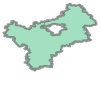

In [90]:
gid = 14 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

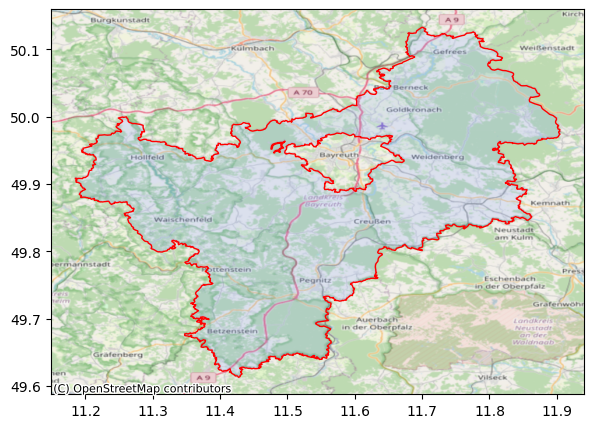

Polygon


In [91]:
vizVectorGeom(INPUT)

In [92]:
len(INPUT.interiors)

3

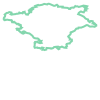

In [93]:
INPUT.interiors[0]

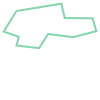

In [94]:
INPUT.interiors[1]

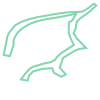

In [97]:
INPUT.interiors[2]

In [276]:
qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

14: Polygon is processing
14: Polygon Ring Detected


9.840136778115507

14: Polygon is processing
14: Polygon Ring Detected


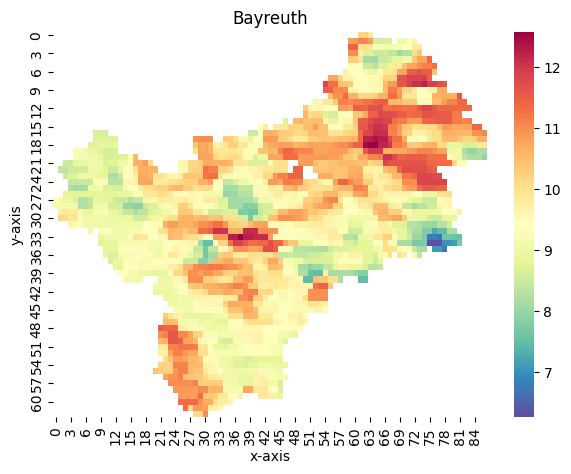

True

In [277]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Bayreuth", 0)

### Cham (IV)

Cham


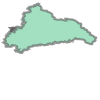

In [26]:
gid = 17 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

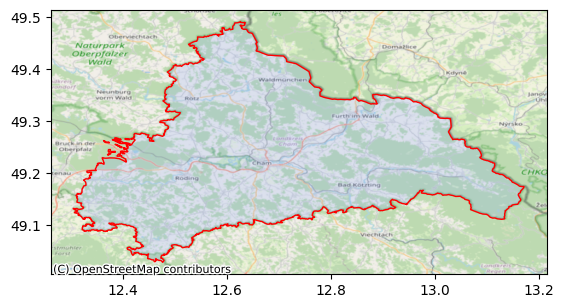

MultiPolygon


In [27]:
vizVectorGeom(INPUT)

In [28]:
list(INPUT.geoms)

[<POLYGON ((12.495 49.061, 12.494 49.061, 12.493 49.06, 12.493 49.06, 12.493 ...>,
 <POLYGON ((12.372 49.237, 12.372 49.237, 12.374 49.238, 12.374 49.238, 12.37...>,
 <POLYGON ((12.379 49.241, 12.381 49.241, 12.385 49.241, 12.385 49.24, 12.381...>,
 <POLYGON ((12.371 49.243, 12.373 49.245, 12.373 49.245, 12.376 49.245, 12.37...>,
 <POLYGON ((12.395 49.25, 12.395 49.25, 12.392 49.251, 12.392 49.251, 12.39 4...>,
 <POLYGON ((12.368 49.26, 12.37 49.259, 12.37 49.259, 12.372 49.26, 12.373 49...>,
 <POLYGON ((12.385 49.267, 12.385 49.267, 12.387 49.267, 12.387 49.267, 12.38...>,
 <POLYGON ((12.408 49.264, 12.408 49.264, 12.407 49.264, 12.405 49.264, 12.40...>]

In [29]:
count = 0
x = 0.0
for polygon in INPUT.geoms:
    qAGGREGATE= 'select avg_cells(clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(polygon)) + ')) from Bavaria_Temperature_MODIS_1km as m'
    x = x + query2numeric(qAGGREGATE)
    count = count+1
    
x_avg = x/count
print(x_avg, count)

None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
None: Polygon is processing
10.703588444213464 8


In [30]:
i = 0 
polygons_array2 = []
for polygon in INPUT.geoms:
    gridPOLYGON = processPOLYGON(polygon)
    polygons_array2.append(gridPOLYGON)
    i = i +1
    print(f"flag {i}") # i th inner polygon
            

flag 1
flag 2
flag 3
flag 4
flag 5
flag 6
flag 7
flag 8


In [31]:
polygons_array2

['POLYGON ((180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 422, 180 422, 180 421, 180 421, 181 421, 181 421, 181 421, 181 421, 181 421, 181 420, 181 420, 181 420, 181 421, 181 420, 181 420, 181 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 420, 182 419, 182 419, 182 420, 182 419, 182 419, 182 419, 182 419, 182 419, 182 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 184 419, 184 419, 184 419, 184 419, 184 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 419, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 418, 183 417, 183 417, 183 417, 183 417, 183 416, 183 416, 183 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 416, 182 415, 182 415, 182 415, 182 415, 182 414, 182 414, 182 414, 182 414, 182 414, 182 414, 182 414, 182 414, 181 414, 181 414, 181 413, 181 413

In [32]:
gridMULTI =  [shapely.wkt.loads(poly) for poly in polygons_array2]

In [33]:
gridMULTI

[<POLYGON ((180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 180 421, 18...>,
 <POLYGON ((159 407, 159 407, 158 407, 158 407, 158 407, 159 407, 159 407, 15...>,
 <POLYGON ((158 408, 158 408, 158 408, 158 408, 158 408, 158 407, 158 407, 15...>,
 <POLYGON ((158 407, 158 407, 158 407, 158 407, 158 407, 158 407, 158 407, 15...>,
 <POLYGON ((157 409, 157 409, 157 409, 157 409, 157 409, 157 409, 157 409, 15...>,
 <POLYGON ((156 406, 156 406, 156 406, 156 407, 156 407, 156 407, 156 407, 15...>,
 <POLYGON ((155 408, 155 408, 155 408, 155 408, 155 408, 155 408, 155 408, 15...>,
 <POLYGON ((155 411, 155 411, 155 411, 155 411, 155 411, 155 410, 155 411, 15...>]

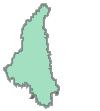

In [34]:
from shapely.ops import unary_union
cu = unary_union(gridMULTI)
cu

In [35]:
print(cu)

MULTIPOLYGON (((157 409, 157 408, 156 408, 157 409)), ((181 420, 182 420, 182 419, 183 419, 183 418, 183 417, 183 416, 182 416, 182 415, 182 414, 181 414, 181 413, 180 413, 180 414, 179 414, 179 413, 178 413, 177 413, 176 413, 176 412, 175 412, 175 411, 175 410, 175 409, 175 408, 176 409, 176 408, 176 407, 176 406, 176 405, 176 404, 176 403, 176 402, 176 401, 175 401, 175 402, 175 403, 174 403, 174 402, 173 402, 173 401, 173 400, 172 400, 172 399, 171 399, 171 400, 170 400, 170 399, 169 400, 169 399, 168 400, 168 401, 167 401, 166 401, 165 401, 164 401, 164 402, 164 403, 163 403, 163 402, 162 402, 162 403, 162 404, 161 404, 161 405, 161 406, 160 405, 160 406, 160 407, 160 408, 160 409, 160 410, 159 410, 159 409, 158 409, 158 410, 157 410, 158 411, 157 411, 157 412, 156 411, 156 412, 156 413, 155 413, 154 413, 154 414, 154 415, 154 416, 155 416, 156 416, 156 417, 155 417, 154 417, 154 418, 154 419, 154 420, 153 420, 152 421, 152 420, 151 419, 151 420, 151 421, 151 422, 150 422, 150 423,

In [25]:
qAGGREGATE= 'select avg_cells(clip(m[273, 0:* , 0:*],'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

17: MultiPolygon is processing


14205.956869565218

17: MultiPolygon is processing


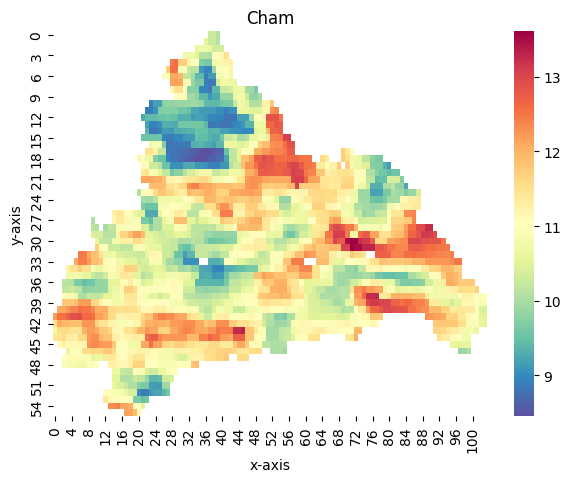

True

In [42]:
qTEST= 'select clip((m[273, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Bavaria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Cham", 0)

### Göteborg (IV)

Göteborg


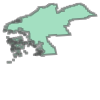

In [15]:
gid = 246 #246 
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

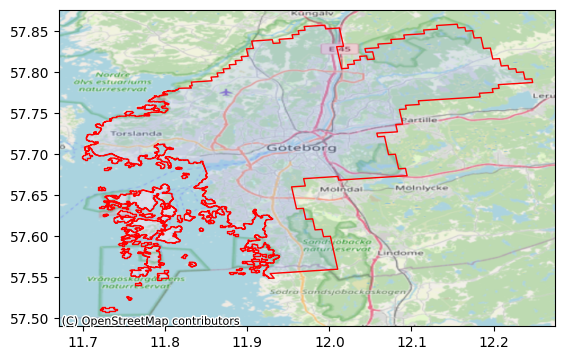

MultiPolygon


In [16]:
vizVectorGeom(INPUT)

In [24]:
i = 0
polygons_array2 = []
for polygon in INPUT.geoms:
    gridPOLYGON = processPOLYGON(polygon)
    polygons_array2.append(gridPOLYGON)
    i = i +1
    print(f"island {i}") # i th inner polygon
            

island 1
island 2
island 3
island 4
island 5
island 6
island 7
island 8
island 9
island 10
island 11
island 12
island 13
island 14
island 15
island 16
island 17
island 18
island 19
island 20
island 21
island 22
island 23
island 24
island 25
island 26
island 27
island 28
island 29
island 30
island 31
island 32
island 33
island 34
island 35
island 36
island 37
island 38
island 39
island 40
island 41
island 42
island 43
island 44
island 45
island 46
island 47
island 48
island 49
island 50
island 51
island 52
island 53
island 54
island 55
island 56
island 57
island 58
island 59
island 60
island 61
island 62
island 63
island 64
island 65
island 66
island 67
island 68


In [10]:
gridMULTI =  [shapely.wkt.loads(poly) for poly in polygons_array2]

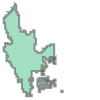

In [11]:
cu = unary_union(gridMULTI)
cu

In [391]:
IN = shapely.geometry.MultiPolygon(cu)

In [31]:
qAGGREGATE= 'select avg_cells(clip((m[145, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ')) from Surface_Temperature_Sweden as m'
query2numeric(qAGGREGATE)

None: MultiPolygon is processing


15.929312977099277

### Rosenheim (V)

Rosenheim


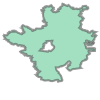

In [49]:
gid = 76 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

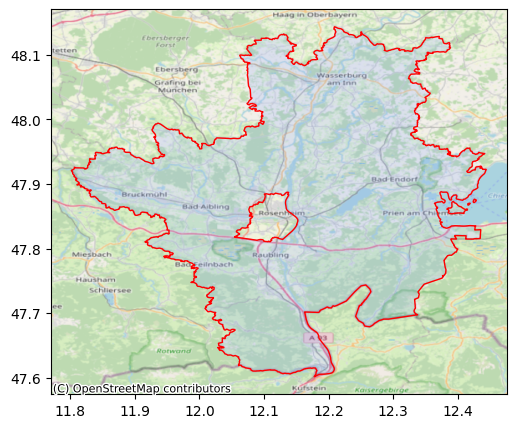

MultiPolygon


In [50]:
vizVectorGeom(INPUT)

In [51]:
qAGGREGATE= 'select avg_cells(clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


13.543174423004112

In [52]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Rosenheim - Main Polygon", 0)

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


Exception: Error executing query 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,MULTIPOLYGON (((350 386, 350 386, 351 386, 351 386, 351 386, 351 386, 351 386, 351 386, 352 386, 352 386, 352 386, 352 386, 352 387, 352 387, 352 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 355 384, 355 384, 355 384, 355 384, 355 384, 355 384, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 384, 355 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 353 384, 353 384, 353 384, 353 384, 353 384, 353 384, 353 384, 353 383, 353 383, 353 383, 353 383, 353 383, 353 383, 353 383, 353 383, 353 383, 353 383, 353 383, 353 383, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 382, 353 381, 353 381, 353 381, 353 381, 353 381, 354 381, 354 381, 354 381, 354 381, 354 381, 354 381, 354 381, 354 381, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 380, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 379, 354 378, 354 378, 354 378, 354 378, 354 378, 354 378, 354 378, 354 378, 354 377, 354 377, 354 377, 354 377, 354 377, 354 377, 354 377, 354 377, 354 377, 354 377, 354 377, 354 376, 354 376, 354 376, 354 376, 354 376, 354 376, 354 376, 354 375, 354 375, 354 375, 354 375, 354 375, 354 375, 354 375, 354 375, 354 374, 354 374, 354 374, 354 374, 354 374, 354 373, 354 373, 354 373, 354 373, 354 373, 354 373, 354 372, 354 372, 354 372, 354 372, 354 372, 354 372, 353 372, 353 371, 353 371, 353 371, 353 371, 353 371, 353 371, 353 371, 353 370, 353 370, 353 370, 353 370, 353 370, 353 369, 353 369, 353 369, 353 369, 353 369, 352 369, 352 369, 352 369, 352 369, 352 369, 351 369, 351 369, 351 369, 351 368, 351 368, 351 367, 351 367, 351 367, 350 367, 350 366, 350 366, 350 366, 350 366, 350 366, 350 366, 349 365, 349 366, 349 366, 349 366, 349 367, 349 367, 349 366, 349 366, 349 366, 349 366, 349 366, 348 366, 348 366, 348 366, 348 366, 348 366, 348 366, 348 367, 348 367, 348 367, 347 367, 347 367, 347 367, 347 367, 347 368, 347 368, 347 368, 346 368, 346 369, 346 369, 346 368, 346 368, 346 368, 346 367, 346 367, 346 367, 346 367, 346 367, 345 366, 345 366, 345 366, 345 366, 345 366, 345 366, 345 366, 344 366, 344 366, 344 366, 344 366, 344 365, 344 365, 344 365, 344 365, 344 364, 344 364, 344 365, 343 365, 343 365, 343 365, 343 365, 343 365, 343 365, 343 365, 343 365, 343 365, 343 364, 343 364, 343 364, 343 364, 343 363, 342 363, 342 363, 342 363, 342 363, 342 363, 342 363, 342 363, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 341 364, 340 365, 340 364, 340 365, 340 365, 340 364, 340 364, 340 364, 340 364, 340 364, 340 363, 340 363, 340 363, 340 363, 340 363, 340 363, 340 363, 340 364, 340 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 364, 339 365, 339 365, 338 365, 338 364, 338 364, 338 364, 338 364, 338 364, 338 364, 338 364, 338 364, 338 364, 338 364, 338 364, 338 364, 338 363, 338 363, 338 363, 338 363, 338 363, 338 362, 338 362, 338 362, 338 362, 338 362, 338 361, 337 361, 337 360, 337 361, 337 361, 337 361, 337 361, 337 361, 336 361, 336 361, 336 361, 336 361, 336 361, 336 361, 336 361, 336 361, 335 361, 335 361, 335 361, 335 361, 335 361, 335 361, 335 361, 335 361, 335 361, 335 361, 335 362, 335 362, 335 361, 335 361, 335 361, 334 361, 335 361, 335 361, 335 361, 334 361, 334 361, 334 360, 334 361, 334 361, 334 361, 334 361, 334 361, 334 360, 334 360, 333 360, 333 360, 333 359, 333 359, 333 359, 333 359, 333 359, 333 359, 333 358, 333 358, 333 358, 333 357, 333 357, 333 357, 333 356, 333 356, 333 356, 333 356, 333 356, 333 356, 333 356, 333 356, 332 355, 332 356, 332 356, 332 356, 332 356, 332 356, 332 356, 332 357, 332 357, 332 356, 332 357, 332 357, 332 357, 332 357, 332 357, 332 357, 332 357, 332 356, 332 357, 332 356, 332 356, 332 356, 332 356, 331 356, 332 356, 332 356, 332 356, 331 356, 331 356, 331 356, 331 356, 331 356, 331 356, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 355, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 354, 331 353, 331 353, 331 353, 331 353, 331 353, 330 353, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 330 352, 329 352, 329 352, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 353, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 354, 329 355, 329 355, 329 355, 329 355, 329 355, 329 355, 329 355, 329 355, 329 355, 329 355, 329 355, 329 355, 328 355, 328 355, 328 355, 328 355, 328 355, 328 355, 328 355, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 328 356, 327 356, 327 356, 327 356, 327 356, 327 356, 327 356, 327 356, 326 356, 326 356, 326 356, 326 356, 326 356, 326 355, 326 356, 326 356, 326 356, 326 356, 326 356, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 355, 325 354, 325 354, 325 354, 325 354, 325 354, 325 354, 325 353, 325 353, 325 353, 325 353, 325 353, 325 353, 325 353, 325 353, 325 353, 324 352, 324 352, 324 352, 324 351, 324 351, 324 351, 324 351, 325 351, 325 351, 325 350, 325 350, 325 350, 325 350, 325 350, 325 350, 324 350, 324 350, 324 350, 324 350, 324 350, 324 349, 324 349, 324 349, 324 349, 324 349, 324 349, 323 349, 323 349, 323 349, 323 349, 323 348, 323 348, 323 348, 323 348, 323 348, 323 348, 323 348, 323 347, 324 347, 324 347, 324 347, 324 347, 324 346, 324 346, 324 346, 324 346, 324 346, 324 346, 324 346, 324 346, 324 346, 324 345, 323 345, 323 345, 323 345, 323 345, 323 345, 323 345, 323 345, 323 345, 323 345, 323 345, 323 345, 323 344, 323 344, 322 344, 322 343, 322 343, 322 343, 322 343, 322 343, 321 343, 321 343, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 321 342, 320 342, 320 342, 320 342, 320 342, 320 342, 320 342, 320 341, 320 341, 320 341, 320 341, 320 341, 320 341, 320 340, 320 340, 320 340, 319 340, 319 340, 319 340, 319 339, 319 339, 319 339, 319 340, 319 340, 319 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 318 339, 317 339, 317 339, 317 339, 317 339, 317 339, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 317 338, 316 339, 316 339, 316 339, 316 339, 316 339, 316 339, 316 340, 316 340, 316 340, 316 341, 316 341, 316 341, 316 341, 316 341, 315 341, 315 342, 315 342, 315 342, 315 341, 315 341, 315 341, 315 342, 315 342, 315 342, 315 342, 314 342, 314 342, 314 342, 314 342, 314 342, 314 342, 314 343, 314 343, 314 343, 314 343, 314 343, 314 343, 314 343, 313 343, 313 343, 313 343, 313 343, 313 343, 313 343, 313 343, 313 343, 313 343, 313 343, 313 344, 313 344, 313 344, 313 344, 313 344, 313 344, 313 344, 313 344, 313 344, 313 345, 313 345, 313 345, 313 345, 313 345, 313 345, 313 345, 313 345, 313 345, 313 345, 312 345, 312 345, 312 345, 312 346, 312 346, 312 346, 312 346, 312 347, 312 347, 312 347, 312 347, 312 348, 313 348, 313 348, 313 348, 313 348, 313 348, 313 348, 313 348, 313 349, 313 349, 313 349, 313 349, 313 349, 313 349, 313 349, 313 349, 314 349, 314 349, 314 349, 314 349, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 350, 314 351, 314 351, 314 351, 314 351, 314 351, 314 351, 315 351, 315 352, 315 352, 315 352, 315 352, 315 352, 315 352, 315 352, 315 352, 315 353, 315 353, 315 353, 315 353, 315 353, 315 353, 315 353, 315 354, 315 354, 315 353, 314 353, 314 354, 314 354, 314 354, 314 354, 314 355, 314 355, 314 355, 314 355, 314 355, 314 355, 314 355, 314 355, 314 356, 314 356, 314 355, 313 355, 314 355, 313 355, 313 354, 313 354, 313 355, 312 354, 312 354, 312 354, 312 354, 312 354, 311 354, 311 354, 311 354, 311 354, 311 354, 310 354, 310 354, 310 354, 310 354, 310 354, 310 354, 310 354, 309 353, 309 353, 309 353, 309 353, 309 353, 308 353, 308 354, 308 354, 308 354, 308 354, 308 354, 308 355, 308 355, 308 355, 308 355, 309 356, 309 356, 309 356, 309 356, 309 356, 309 356, 309 356, 309 357, 309 357, 309 357, 309 357, 309 357, 309 357, 309 357, 309 357, 309 358, 309 358, 309 358, 309 358, 309 358, 310 358, 310 359, 310 359, 310 359, 310 359, 310 359, 310 359, 310 359, 310 359, 310 359, 310 359, 310 360, 310 360, 310 360, 310 360, 310 360, 310 360, 310 360, 310 361, 311 361, 311 361, 311 361, 311 361, 311 361, 311 361, 311 361, 311 361, 311 361, 311 361, 311 361, 312 362, 312 362, 312 362, 312 362, 313 362, 312 362, 312 362, 312 363, 312 363, 311 362, 311 363, 312 363, 312 363, 312 363, 312 364, 312 364, 312 364, 312 365, 311 365, 311 365, 311 365, 311 365, 311 365, 311 365, 310 365, 310 365, 311 366, 311 367, 311 367, 311 368, 311 368, 311 368, 311 368, 311 368, 311 368, 311 368, 311 368, 311 369, 311 369, 311 369, 311 369, 311 369, 311 369, 310 370, 310 370, 310 370, 310 370, 310 370, 310 370, 310 370, 310 371, 310 371, 309 371, 309 371, 309 370, 309 370, 308 371, 308 371, 308 371, 308 371, 308 371, 308 372, 308 372, 308 372, 308 372, 308 373, 308 373, 308 373, 308 373, 308 373, 308 373, 308 373, 308 374, 308 374, 308 374, 308 374, 307 374, 307 374, 307 374, 307 373, 307 373, 307 373, 307 374, 307 374, 307 374, 307 374, 307 374, 306 374, 306 374, 306 374, 306 374, 306 374, 306 374, 306 374, 306 374, 305 373, 305 373, 305 372, 305 372, 305 373, 305 372, 305 372, 305 372, 305 372, 305 372, 305 372, 305 372, 305 372, 305 372, 305 371, 304 372, 304 372, 305 372, 305 372, 305 372, 305 372, 305 372, 305 373, 305 373, 304 373, 304 373, 304 372, 304 372, 304 372, 304 372, 304 372, 304 372, 304 372, 304 372, 304 372, 304 372, 304 372, 304 371, 304 371, 304 371, 304 371, 304 371, 304 371, 303 372, 303 372, 303 372, 303 372, 303 372, 303 372, 303 372, 302 372, 302 371, 301 371, 301 371, 301 371, 301 371, 301 371, 301 371, 300 371, 299 371, 299 371, 299 371, 299 371, 299 371, 299 371, 298 371, 298 371, 298 371, 298 371, 298 371, 297 371, 297 371, 297 371, 297 371, 297 371, 297 371, 297 371, 297 371, 297 371, 296 371, 296 370, 296 370, 296 370, 296 370, 296 370, 296 370, 296 370, 295 369, 295 370, 295 370, 295 371, 295 371, 295 371, 295 371, 295 372, 294 371, 294 371, 294 371, 294 371, 294 371, 293 371, 293 371, 293 371, 293 371, 293 371, 293 372, 293 372, 293 373, 292 372, 292 372, 292 372, 292 372, 292 372, 292 373, 292 374, 292 374, 292 374, 292 374, 292 375, 292 375, 292 375, 292 375, 292 375, 292 376, 292 376, 292 376, 292 376, 292 376, 292 376, 292 377, 292 377, 291 377, 291 377, 291 378, 291 378, 291 378, 291 378, 291 378, 292 378, 292 378, 292 378, 292 378, 292 378, 292 378, 292 378, 293 379, 293 379, 293 379, 293 379, 293 379, 293 379, 293 379, 293 379, 293 379, 293 380, 293 380, 293 380, 293 380, 293 380, 293 380, 294 379, 294 379, 294 379, 294 379, 294 379, 294 380, 294 379, 294 379, 294 379, 295 378, 295 379, 295 378, 295 378, 295 378, 295 378, 295 379, 296 378, 296 378, 296 378, 296 379, 296 379, 296 379, 296 379, 296 379, 296 379, 296 379, 296 379, 296 379, 296 379, 296 379, 297 379, 297 379, 297 380, 297 380, 297 380, 296 380, 296 380, 297 380, 297 381, 297 381, 297 381, 297 381, 297 382, 297 382, 297 382, 297 382, 297 382, 296 382, 296 382, 296 383, 296 383, 296 383, 296 383, 296 383, 296 383, 296 383, 296 384, 296 384, 296 384, 296 384, 296 384, 295 384, 295 384, 295 384, 295 383, 295 383, 295 383, 295 383, 294 383, 294 383, 294 383, 294 384, 294 384, 294 384, 294 385, 294 385, 294 385, 294 385, 294 385, 294 385, 293 385, 293 385, 293 385, 293 385, 293 385, 293 385, 293 386, 292 386, 292 386, 292 386, 292 387, 292 387, 292 387, 291 387, 291 387, 291 387, 290 387, 290 387, 290 387, 290 387, 290 387, 290 387, 290 387, 290 387, 290 387, 290 387, 290 387, 290 388, 290 388, 290 388, 290 388, 290 388, 290 388, 290 388, 290 388, 290 388, 290 388, 290 388, 290 389, 290 389, 290 389, 290 389, 291 389, 291 389, 291 389, 291 389, 291 389, 291 390, 291 390, 291 390, 291 390, 291 390, 291 390, 291 390, 291 390, 291 391, 291 391, 291 391, 291 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 391, 292 392, 292 392, 292 392, 292 392, 292 392, 292 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 392, 291 393, 291 393, 292 393, 292 393, 292 393, 292 393, 292 393, 292 393, 292 394, 293 394, 293 394, 293 394, 293 394, 293 395, 293 395, 293 395, 293 395, 293 395, 293 396, 293 396, 293 396, 293 396, 293 396, 293 396, 293 396, 293 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 396, 294 397, 294 397, 294 397, 294 397, 294 397, 294 397, 294 397, 294 397, 294 397, 294 397, 294 397, 294 397, 294 398, 294 398, 294 398, 294 398, 294 398, 294 398, 294 398, 294 398, 294 399, 294 399, 294 399, 294 399, 294 399, 294 399, 294 399, 294 399, 294 399, 294 399, 294 399, 294 400, 294 400, 294 400, 294 400, 294 400, 294 400, 294 400, 294 400, 294 400, 294 401, 294 401, 294 401, 294 401, 294 401, 294 401, 294 401, 294 401, 294 402, 294 402, 294 402, 294 402, 294 402, 294 402, 294 402, 294 402, 294 402, 294 402, 294 403, 294 403, 294 403, 294 403, 293 403, 293 403, 293 403, 293 404, 293 404, 292 404, 292 404, 292 404, 292 404, 292 405, 292 405, 292 405, 292 405, 292 405, 292 406, 292 407, 292 407, 292 407, 292 407, 292 407, 292 407, 293 407, 293 407, 293 407, 293 407, 293 408, 293 408, 293 408, 293 408, 293 408, 293 409, 293 408, 293 408, 293 408, 293 409, 293 409, 293 409, 293 408, 294 408, 294 409, 294 409, 294 408, 294 408, 294 408, 295 408, 295 408, 294 407, 295 407, 294 406, 294 406, 294 406, 295 405, 295 405, 295 405, 295 405, 295 405, 295 405, 295 404, 295 404, 295 404, 295 405, 295 404, 295 404, 295 404, 295 404, 296 404, 296 404, 296 404, 296 404, 296 404, 296 404, 296 404, 296 404, 296 403, 296 403, 296 403, 296 403, 296 403, 296 402, 296 402, 296 402, 296 402, 296 402, 296 402, 297 402, 297 402, 297 402, 297 402, 297 402, 297 402, 297 402, 297 402, 297 402, 297 403, 298 403, 298 403, 298 403, 298 403, 298 403, 298 402, 298 402, 298 402, 298 402, 298 402, 298 402, 298 402, 298 403, 298 403, 298 403, 298 403, 299 403, 299 403, 299 402, 299 402, 299 402, 299 401, 299 401, 299 401, 299 401, 299 401, 299 401, 300 401, 300 401, 300 401, 300 401, 300 402, 300 402, 300 402, 300 402, 300 402, 300 402, 300 403, 300 403, 300 403, 301 403, 301 403, 301 403, 301 403, 301 404, 301 404, 301 404, 301 404, 301 404, 302 404, 302 404, 302 404, 302 405, 302 405, 302 405, 302 405, 303 405, 303 404, 303 404, 303 404, 303 404, 303 404, 304 404, 304 404, 304 403, 304 403, 304 403, 304 403, 304 403, 304 403, 304 403, 304 402, 304 402, 304 403, 305 403, 305 402, 305 402, 305 402, 305 402, 305 402, 305 402, 306 402, 306 402, 306 402, 306 402, 306 402, 306 403, 306 403, 306 403, 307 403, 307 403, 307 403, 307 403, 307 402, 308 403, 308 402, 308 403, 308 402, 308 402, 308 402, 308 402, 309 402, 309 402, 309 402, 309 402, 309 402, 309 402, 309 402, 309 402, 309 402, 309 402, 310 401, 310 401, 310 401, 310 401, 310 401, 310 402, 310 402, 310 402, 310 402, 311 402, 311 402, 311 402, 311 402, 311 403, 311 403, 311 403, 311 403, 311 404, 311 404, 311 404, 312 404, 312 404, 312 404, 312 404, 312 404, 312 404, 312 404, 312 404, 312 404, 312 405, 312 405, 312 405, 312 405, 312 406, 312 406, 312 406, 312 406, 312 406, 312 406, 312 406, 312 406, 312 407, 312 407, 312 407, 312 407, 313 407, 313 407, 313 407, 313 408, 313 408, 312 408, 312 408, 313 408, 313 408, 313 408, 313 408, 313 409, 313 409, 313 409, 313 408, 313 408, 313 408, 313 408, 313 408, 313 408, 314 408, 314 408, 314 408, 314 409, 314 409, 314 409, 314 409, 314 409, 314 409, 314 409, 314 409, 314 409, 314 410, 314 410, 314 410, 314 410, 314 410, 314 410, 314 410, 314 410, 314 410, 314 410, 314 410, 314 410, 313 410, 313 410, 313 410, 313 411, 313 411, 313 411, 313 411, 313 411, 313 411, 313 411, 313 411, 313 411, 313 411, 312 412, 312 412, 312 412, 312 412, 312 412, 312 412, 312 412, 312 412, 313 412, 313 412, 313 412, 313 412, 313 412, 313 412, 313 412, 313 413, 313 413, 313 413, 313 413, 313 413, 313 413, 313 413, 313 413, 314 413, 313 413, 313 413, 313 414, 313 414, 313 414, 313 414, 313 414, 313 414, 313 414, 313 414, 313 415, 313 415, 313 415, 314 415, 314 415, 314 415, 314 414, 314 414, 314 414, 314 414, 314 414, 314 414, 314 414, 314 414, 314 414, 314 414, 314 414, 314 414, 315 414, 315 413, 315 413, 315 413, 315 413, 315 413, 315 413, 315 413, 315 413, 315 413, 316 413, 316 413, 316 413, 316 413, 316 412, 316 412, 316 412, 316 412, 317 412, 317 412, 317 412, 317 412, 317 412, 317 412, 317 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 413, 316 414, 316 414, 316 414, 316 414, 316 414, 316 414, 316 414, 316 414, 316 414, 316 414, 316 414, 316 415, 316 415, 316 415, 316 415, 316 415, 316 415, 316 415, 316 415, 316 415, 316 415, 316 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 317 415, 318 414, 318 414, 318 414, 318 414, 318 414, 318 414, 318 414, 318 414, 318 414, 318 414, 318 414, 318 414, 319 414, 319 414, 319 414, 319 414, 319 414, 319 414, 319 414, 319 414, 319 414, 319 414, 319 414, 319 414, 320 414, 320 414, 320 414, 320 414, 320 414, 320 413, 320 413, 320 413, 320 413, 320 413, 320 413, 320 413, 320 413, 320 413, 320 413, 320 413, 320 413, 321 413, 321 413, 321 413, 321 412, 321 412, 321 412, 321 412, 321 412, 321 412, 321 412, 321 412, 321 412, 321 412, 321 412, 321 412, 322 412, 322 412, 322 412, 322 412, 322 412, 322 412, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 411, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 322 410, 321 410, 321 410, 321 410, 321 410, 321 410, 321 410, 321 410, 321 410, 321 410, 321 410, 321 409, 321 409, 321 409, 321 409, 321 409, 321 409, 321 409, 321 409, 321 409, 321 409, 321 409, 321 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 408, 322 408, 322 408, 322 408, 322 408, 322 408, 322 408, 322 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 408, 321 407, 321 407, 321 407, 321 407, 320 407, 320 407, 320 407, 320 407, 321 407, 321 407, 321 407, 321 407, 321 407, 321 407, 321 407, 321 407, 321 407, 321 407, 321 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 408, 322 408, 322 408, 322 408, 322 408, 322 408, 322 408, 322 408, 322 408, 323 407, 323 407, 323 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 407, 322 406, 322 406, 322 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 323 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 324 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 406, 325 407, 325 407, 325 407, 325 407, 325 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 326 407, 327 407, 327 407, 327 407, 327 407, 327 407, 327 407, 327 407, 327 407, 327 408, 327 408, 327 408, 327 408, 327 408, 327 408, 327 408, 327 408, 327 408, 327 408, 327 408, 327 408, 327 409, 327 409, 327 409, 327 409, 327 409, 327 409, 327 409, 327 409, 327 409, 327 409, 327 409, 327 410, 327 410, 327 410, 327 410, 327 410, 327 410, 327 410, 327 411, 327 411, 327 411, 327 411, 327 412, 327 412, 327 412, 327 412, 327 412, 327 413, 327 413, 327 413, 328 413, 328 413, 328 414, 328 414, 328 414, 329 414, 329 414, 329 414, 329 414, 329 414, 329 414, 329 413, 329 413, 329 413, 329 412, 329 411, 329 412, 329 411, 329 409, 329 409, 329 410, 329 410, 329 410, 329 409, 329 409, 329 409, 329 409, 329 409, 330 409, 330 409, 330 409, 330 409, 331 409, 331 409, 331 409, 331 410, 331 410, 331 410, 331 410, 331 410, 331 410, 331 410, 331 410, 331 410, 332 410, 332 410, 332 409, 332 409, 332 408, 332 408, 333 407, 333 407, 334 408, 335 408, 335 408, 336 408, 336 407, 336 407, 336 407, 336 407, 336 407, 337 407, 337 405, 338 404, 339 403, 339 403, 339 403, 339 403, 340 403, 340 403, 340 402, 340 402, 341 402, 342 402, 342 402, 342 402, 342 402, 343 402, 343 402, 343 402, 343 402, 343 403, 343 402, 343 402, 343 402, 343 402, 343 402, 343 402, 343 402, 343 401, 343 401, 343 401, 343 401, 343 401, 343 401, 343 401, 344 401, 344 401, 344 401, 344 401, 344 401, 344 400, 344 400, 344 400, 344 400, 344 400, 344 400, 344 400, 344 400, 344 399, 344 399, 344 399, 344 399, 344 399, 344 399, 344 399, 344 399, 344 398, 344 398, 344 398, 344 398, 344 398, 344 398, 344 397, 344 397, 344 397, 344 397, 344 397, 344 397, 344 397, 344 397, 344 397, 344 397, 344 396, 344 396, 344 396, 344 396, 344 396, 344 396, 344 396, 344 396, 344 396, 344 396, 344 396, 344 396, 344 395, 344 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 395, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 345 394, 346 394, 346 394, 346 394, 346 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 393, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 345 392, 344 392, 344 392, 344 392, 344 392, 344 392, 344 392, 344 392, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 344 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 343 391, 342 391, 342 391, 342 391, 342 391, 342 391, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 342 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 392, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 341 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 393, 340 394, 339 394, 339 394, 339 394, 339 394, 339 394, 339 394, 339 394, 339 394, 338 393, 338 393, 338 393, 338 393, 338 393, 338 393, 338 393, 338 393, 338 393, 338 393, 338 392, 338 392, 338 392, 338 392, 338 392, 338 392, 338 392, 338 392, 338 392, 338 392, 338 391, 339 391, 339 391, 339 391, 339 391, 339 391, 339 391, 339 391, 339 391, 339 391, 339 391, 339 390, 339 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 340 390, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 389, 341 388, 342 388, 342 388, 342 387, 342 387, 342 387, 342 387, 342 387, 342 387, 342 387, 342 387, 342 387, 342 387, 342 387, 342 387, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 386, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 385, 342 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 384, 343 383, 343 383, 343 383, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 343 382, 344 382, 344 382, 344 382, 345 382, 345 382, 345 382, 345 382, 345 382, 345 382, 345 382, 346 382, 346 383, 346 383, 346 383, 346 383, 346 383, 346 383, 346 383, 346 383, 346 384, 346 384, 346 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 347 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 384, 348 385, 348 385, 349 385, 349 385, 349 385, 349 385, 349 385, 349 385, 349 385, 349 385, 349 386, 350 386, 350 386, 350 386, 350 386, 350 386, 350 386, 350 386, 350 386, 350 386, 350 386)), ((324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 325 411, 325 411, 325 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 410, 324 409, 324 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 409, 325 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 324 408, 323 408, 323 408, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 323 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 322 409, 323 409, 323 409, 323 409, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 410, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 323 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 411, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412, 324 412)), ((323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412, 323 412)), ((322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413, 322 413)))) from Baveria_Temperature_MODIS_1km as m', error message 'rasdaman error 355: Execution error 355 in line 1, column 35417, near token Baveria_Temperature_MODIS_1km: Collection name is unknown.'

In [53]:
INPUT.geom_type

'MultiPolygon'

In [54]:
list(INPUT.geoms)

[<POLYGON ((12.2 47.64, 12.201 47.638, 12.201 47.637, 12.202 47.636, 12.202 4...>,
 <POLYGON ((12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47...>,
 <POLYGON ((12.415 47.868, 12.415 47.868, 12.415 47.869, 12.416 47.869, 12.41...>,
 <POLYGON ((12.425 47.876, 12.426 47.876, 12.426 47.876, 12.426 47.876, 12.42...>]

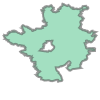

In [55]:
list(INPUT.geoms)[0]

In [56]:
print(list(INPUT.geoms)[0])

POLYGON ((12.200161721000029 47.64013822700002, 12.200831974000153 47.63832113400008, 12.20115869000017 47.63741699900015, 12.201745728000049 47.635656199000096, 12.202132202000087 47.634496923000086, 12.202205343000173 47.63427752000018, 12.20308260100012 47.63117171100015, 12.203171711000039 47.63085622400007, 12.20332435400013 47.62861527899997, 12.203636109000058 47.62667949400014, 12.20367800200006 47.62641931100001, 12.204063286000178 47.6244087770001, 12.204291696000041 47.623539916000084, 12.20460580800011 47.62288023000019, 12.204982143000052 47.6221950690001, 12.206616982000071 47.61921847400009, 12.207421562000036 47.61772136100012, 12.207765814000084 47.61708076200017, 12.208263446000046 47.61599882500008, 12.208520962000023 47.61528756900003, 12.208723547000034 47.614612655000144, 12.208837907000088 47.61403789299999, 12.20888875899999 47.613434442000084, 12.208875864000106 47.61323794700007, 12.208851865000156 47.61287196100017, 12.208733554000048 47.6123095800001, 12.208

In [57]:
list(INPUT.geoms)[0].geom_type

'Polygon'

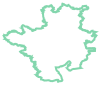

In [58]:
mainRING = list(INPUT.geoms)[0].exterior
mainRING

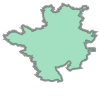

In [59]:
mainPOLYGON = Polygon(list(INPUT.geoms)[0].exterior)
mainPOLYGON

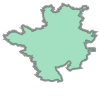

In [60]:
x = list(INPUT.geoms)[0]
Polygon(x.exterior)

In [61]:
list(INPUT.geoms[0].interiors)

[<LINEARRING (12.083 47.865, 12.078 47.865, 12.077 47.86, 12.077 47.858, 12.0...>]

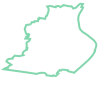

In [62]:
innerRING = list(INPUT.geoms)[0].interiors[0]
innerRING

In [63]:
list(INPUT.geoms)[0].interiors[0].geom_type

'LinearRing'

In [64]:
len(list(INPUT.geoms[0].interiors))

1

In [65]:
len(list(INPUT.geoms[2].interiors))

0

In [66]:
ring = list(INPUT.geoms)[0].interiors[0]
ring.geom_type
ring.is_closed

True

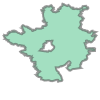

In [67]:
Polygon_assemled = mainPOLYGON.symmetric_difference(Polygon(innerRING))
Polygon_assemled

In [68]:
print(Polygon_assemled)

POLYGON ((12.200831974000153 47.63832113400008, 12.20115869000017 47.63741699900015, 12.201745728000049 47.635656199000096, 12.202132202000087 47.634496923000086, 12.202205343000173 47.63427752000018, 12.20308260100012 47.63117171100015, 12.203171711000039 47.63085622400007, 12.20332435400013 47.62861527899997, 12.203636109000058 47.62667949400014, 12.20367800200006 47.62641931100001, 12.204063286000178 47.6244087770001, 12.204291696000041 47.623539916000084, 12.20460580800011 47.62288023000019, 12.204982143000052 47.6221950690001, 12.206616982000071 47.61921847400009, 12.207421562000036 47.61772136100012, 12.207765814000084 47.61708076200017, 12.208263446000046 47.61599882500008, 12.208520962000023 47.61528756900003, 12.208723547000034 47.614612655000144, 12.208837907000088 47.61403789299999, 12.20888875899999 47.613434442000084, 12.208875864000106 47.61323794700007, 12.208851865000156 47.61287196100017, 12.208733554000048 47.6123095800001, 12.208496883000066 47.611683791000075, 12.20

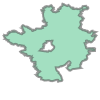

In [25]:
x = list(INPUT.geoms)[0]
x

In [26]:
if x == Polygon_assemled:
    True
else:
    print("Nope")

Nope


In [27]:
gridPOLYGON_yx = wkt.loads(processPOLYGON(mainPOLYGON))
gridPOLYGON_yx

TypeError: unsupported operand type(s) for &: 'int' and 'float'

In [28]:
gridRING_yx = wkt.loads(processPOLYGON(Polygon(innerRING)))
gridRING_yx

TypeError: unsupported operand type(s) for &: 'int' and 'float'

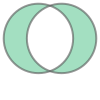

In [29]:
a = Point(1, 1).buffer(1.5)

b = Point(2, 1).buffer(1.5)

a.symmetric_difference(b)

In [30]:
x = gridPOLYGON_yx.symmetric_difference(gridRING_yx)
print(x)

NameError: name 'gridPOLYGON_yx' is not defined

In [31]:
# print(wkt.loads(str(gridPOLYGON_yx - gridRING_yx))) Worked but as a geometry collection

In [32]:
for i in range(0, len(x.interiors)):
    gridRING_yx = processRING(x.interiors[i])
    
print(grid2WKT_ring)

<function grid2WKT_ring at 0x7fb848141ee0>


In [33]:
gridPOLYGON_yx_assembled = gridPOLYGON_yx.symmetric_difference(Polygon(gridRING_yx))
        

NameError: name 'gridPOLYGON_yx' is not defined

### Expected Output

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


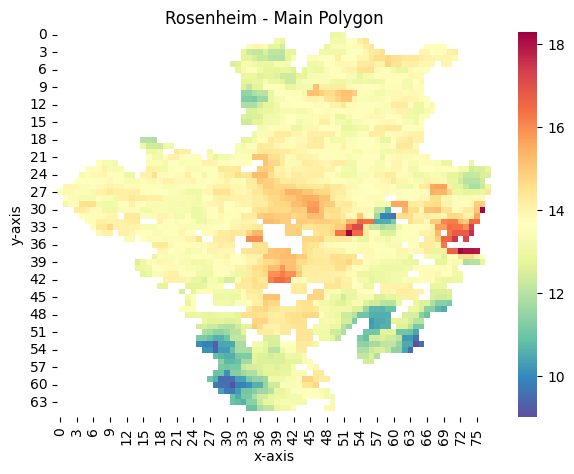

True

In [257]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, "Rosenheim - Main Polygon", 0)

Ostallgäu


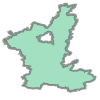

In [284]:
gid = 68 #68 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [285]:
list(INPUT.geoms)

[<POLYGON ((10.597 47.569, 10.597 47.569, 10.597 47.569, 10.597 47.568, 10.59...>,
 <POLYGON ((10.454 47.556, 10.454 47.556, 10.454 47.556, 10.454 47.556))>]

In [286]:
print(INPUT)

MULTIPOLYGON (((10.597360928000171 47.569352456000104, 10.597027419000028 47.568972182000095, 10.596877669000094 47.56880143600017, 10.596556629000133 47.56834053500012, 10.596505727000022 47.5682616740001, 10.596213182999975 47.5677754890001, 10.596176285000126 47.56771416600009, 10.596076402000108 47.567382199000065, 10.596127085000148 47.56619506400017, 10.596286496000118 47.565515285000174, 10.595824063000123 47.565212843000154, 10.595771094999975 47.56519887700006, 10.595022117000042 47.56500139700006, 10.59435970700008 47.5646786260001, 10.594034705000013 47.56448137900003, 10.593605463000074 47.56422086100014, 10.593559867000181 47.5641651040001, 10.593340442000056 47.563896192000016, 10.592924063000169 47.56338629300001, 10.592767788999993 47.56320419400015, 10.592663272000152 47.56308239100014, 10.592336584000122 47.56270145900004, 10.592209734000107 47.56255368300009, 10.591792158000032 47.562066090000144, 10.590886695000165 47.561073805000035, 10.590818370000079 47.560999665

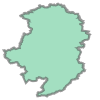

In [235]:
mainPOLYGON = Polygon(list(INPUT.geoms)[0].exterior)
mainPOLYGON

In [42]:
mainPOLYGON.area

0.171788966777449

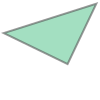

In [43]:
mainPOLYGON = Polygon(list(INPUT.geoms)[1].exterior)
mainPOLYGON

In [44]:
mainPOLYGON.area

3.200172296008267e-11

In [45]:
0.008333333332587>3.200172296008267e-11

True

In [46]:
print(mainPOLYGON)

POLYGON ((10.454469946000074 47.555739956000195, 10.454466610000111 47.55573294600015, 10.454459191000126 47.55573654200009, 10.454469946000074 47.555739956000195))


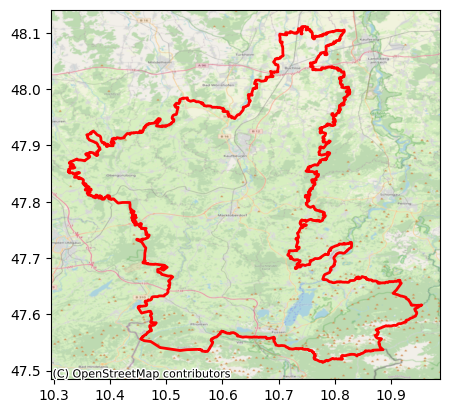

In [51]:
import contextily as cx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape

geojson = {'type': 'Polygon', 'coordinates': [[[34, 31], [32, 31], [34, 33]]]}

gdf = gpd.GeoDataFrame({'geometry':[shape(mainPOLYGON)]}, crs='EPSG:4326')
ax = gdf.plot(facecolor='none', edgecolor='red', linewidth=2)
cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)
plt.show()


In [275]:
pip install contextily

Exception ignored in: <function _after_fork at 0x7f2d81227700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 1457, in _after_fork
    thread._stop()
TypeError: 'Event' object is not callable


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 22.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 10.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


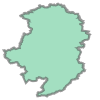

In [227]:
Polygon(mainPOLYGON.exterior)

68: Polygon is processing


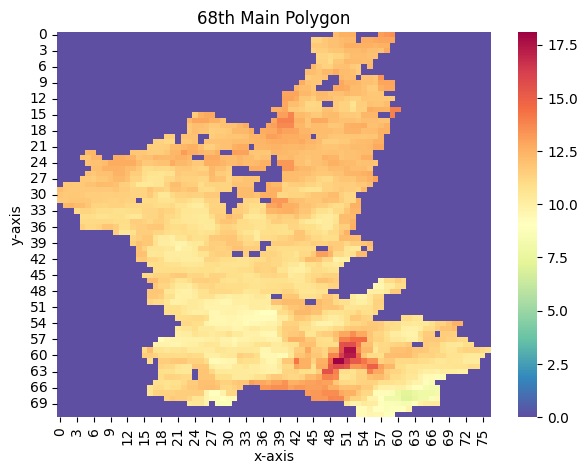

True

In [256]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(mainPOLYGON, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gid) + "th Main Polygon")

In [230]:
qAGGREGATE= 'select avg_cells(clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(mainPOLYGON, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

68: Polygon is processing


11.327328273244813

In [236]:
qAGGREGATE= 'select avg_cells(clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(mainPOLYGON, gid)) + ')) from Bavaria_Temperature_MODIS_1km as m'
query2numeric(qAGGREGATE)

67: Polygon is processing


10.888405904059054

In [ ]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

Würzburg


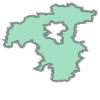

In [230]:
gid = 94
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

94: Polygon is processing
94: Polygon Ring Detected


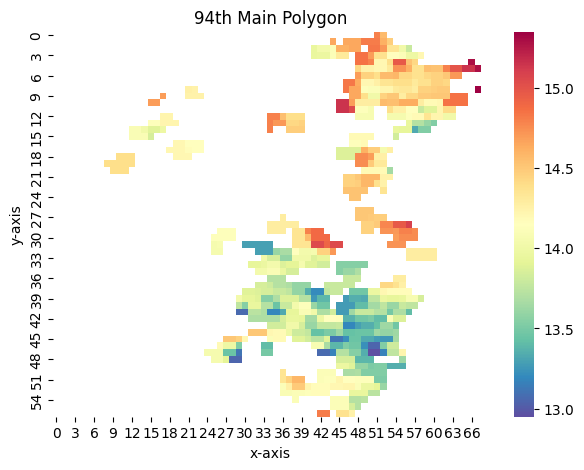

True

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 447, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 73, in rasmgr_keep_alive
    return stub.KeepAlive(make_rasmgr_keep_alive_req(cuuid), _TIMEOUT_SECONDS)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "QThe client with client ID 13116 does not exist: cannot reset clien

In [231]:
qTEST= 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qTEST, str(gid) + "th Main Polygon", 0)

In [120]:
list(INPUT.geoms)

AttributeError: 'Polygon' object has no attribute 'geoms'

In [135]:
y= processPOLYGON(list(INPUT.geoms)[0])
y

AttributeError: 'Polygon' object has no attribute 'geoms'

In [136]:
print(y)

NameError: name 'y' is not defined

In [210]:
qTIME = "select avg_cell(m[246:250, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as m" 
query2numeric(qTIME)

14.335148975105596